File with final parameter estimation code.

## Package Imports

In [1]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Justin's packages - needs bebi103 environment
# import iqplot
# import bebi103

# bokeh.io.output_notebook()

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

import pandas as pd
import ast

from bokeh.plotting import figure, show, curdoc
from bokeh.io import output_notebook
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.themes import Theme
from bokeh.layouts import column, row
output_notebook()

from bokeh.models import ColorBar, LinearColorMapper
from bokeh.palettes import Viridis256, Cividis256, Plasma256, Magma256, Blues8, BuRd
from bokeh.models import ColumnDataSource

from bokeh.models import BasicTicker, PrintfTickFormatter


import scipy as sp
import scipy.stats as st
from scipy.optimize import minimize
# import statsmodels.tools.numdiff as smnd

# Import time
import time
from datetime import datetime

# Numpy imports:    
import numpy as np

# Pandas for csv 
import pandas as pd

# for extracting filenames 
import glob

#Matplotlib imports
import matplotlib.pyplot as plt

# skimage submodules we need
import skimage.io

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

import os

import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

#for saving
import h5py

# Plotting params
size = 500;

Loading BokehJS ...

# Functions

In [2]:
def read_images(datafolder, skip_int = 1, max_image_number = 400):
    # bound Images
    included_bound = '*405*.tif'
    bound_files = np.sort(glob.glob(datafolder+'/'+included_bound))[:max_image_number:skip_int]
    bound_images = [skimage.io.imread(image_location) for image_location in bound_files]; 
    # unbound Images
    included_unbound = '*480*.tif'
    unbound_files = np.sort(glob.glob(datafolder+'/'+included_unbound))[:max_image_number:skip_int]
    unbound_images = [skimage.io.imread(image_location) for image_location in unbound_files]; 

    return bound_images, unbound_images

In [3]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = np.array([skimage.io.imread(image_location) for image_location in dark_files]); 
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg


In [4]:
def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

def norm_unev(arrs_sub):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub: # Iterate over channels
        print("time before polynomial fitting", time.time()); 
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0]) 
        biv_filt = evaluateBivPoly(arr[0, :, :])
        #norm_mats.append(norm_mat)
        print("time after polynomial fitting", time.time());
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image

        scalar = np.mean(arr[0])/np.mean(arr[0]/biv_filt)

        # Normalisation
        norm_mat = scalar/biv_filt
        print("shape of norm mat", norm_mat.shape)
        print("shape of arr", arr.shape)
        print("time after normalising matrix", time.time());

        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp=arr*norm_mat; 
        print("time after multiplying arr with norm_mat", time.time());
        
        arrs_ev.append(arrs_ev_temp)
        print("time after appending", time.time());
        
    return arrs_ev

In [5]:
def grab_calparams(file_path_cal):
    """
    Imports ATP calibration parameters as a DataFrame.
    
    Parameters:
    file_path_cal (string): Data path to a text file with fitting parameters for ATP calibration
    
    Returns:
    cal_params (pd.DataFrame): DataFrame with ATP calibration fitting parameters.
    """
        
    #read the DataFrame
    #cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)\
    cal_params = pd.read_csv(file_path_cal)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

def replace_out_of_range_values(arr, min_value, max_value):
    """
    Crop the intensities of an array to be withing a defined range.
    
    Parameters:
    arr (numpy.ndarray): images array.
    min_value (float): minimum value below which all other values are set to the minimum
    max_value (float): maximum value above which all other values are set to the maximum
    
    Returns:
    arr_copy (numpy.ndarray): image array cropped to the set intensity range.
    """
    arr_copy = np.copy(arr)
    mask_min = arr < min_value
    mask_max = arr > max_value
    arr_copy[mask_min] = min_value
    arr_copy[mask_max] = max_value
    return arr_copy

def ATP_conc_to_ratio(array, Km, Rmax, Rmin, nhill):
    """Given a set of concentrations, returns ratio values based on provided Hill equation coefficients"""
    return (Rmax-Rmin)*((array/Km)**nhill/(1 + (array/Km))**nhill) + Rmin

def ATP_ratio_to_conc(array, Km, Rmax, Rmin, nhill):
    """Given a set of ratios, returns concentration values based on provided Hill equation coefficients"""
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

def infer_concs(ratios, exp_params, cal_params, shape):
    """
    Convert ratios images to concentrations. (outputs an image array)
    
    Parameters:
    ratios (numpy.ndarray): ratio array of shape (# timepoints, #of ratio values to convert).
    exp_params (dictionary): dictonary of experimental parameters
    cal_params (dictionary): maximum value above which all other values are set to the maximum
    allmask_coords (slice): coordinates for multiple timepoints 
    shape (tuple): shape of image array
    
    Returns:
    ratios_conc_ims (numpy.ndarray): image array in concentration units.
    """
    #Find the ratio value for the inital ATP conc value based on calibration curve equation

    print("Find the ratio value for the inital ATP conc value based on calibration curve equation")
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])
    #Crop the ratios to within range
    print("Crop the ratios to within range")
    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)
    #convert ratios to concentrations
    print("convert ratios to concentrations")
    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value'])
    
    return ratios_conc

# Processing

In [6]:
def process_folder(datafolder, skip_int = 1):
    now = time.time()
    print("time", now)
    #--------- Read Images -----------#
    bound_images, unbound_images = read_images(datafolder, skip_int = 1, max_image_number = 400); 
    bound_images = np.array(bound_images, dtype = np.float32); 
    unbound_images = np.array(unbound_images, dtype = np.float32); 
    
    #--------- Read Dark Files -----------#
    dark_avg = grab_dark_avg('../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*');
    dark_avg = dark_avg.astype(np.float32); 
    
    #--------- Subtract Dark Image Background from Experiment Images -----------#
    bound_bs = bound_images - dark_avg; 
    unbound_bs = unbound_images - dark_avg; 
    print("normalisation starting in ", now - time.time(), " s"); 

    #--------- Camera has Uneven Illumincation. Correct this Unevent Illumination in Background Subtracted Images -----------#
    [even_bound_bs, even_unbound_bs] = norm_unev([bound_bs, unbound_bs]); 
    even_bound_bs = even_bound_bs.astype(np.float32)
    even_unbound_bs = even_unbound_bs.astype(np.float32)
    print("normalisation finished in ", now - time.time(), " s"); 
    print("float type bound bs", type(even_bound_bs[0][0][0]))
    #--------- Calculate Ratios -----------#
    ratios_array = even_bound_bs/even_unbound_bs; 
    ratios_array = ratios_array.astype(np.float32)
    print("rations calculated")
    print("float type ratios array", type(ratios_array[0][0][0]))

    #--------- Convert Ratio to ATP -----------#
    cal_file_path = '../../analyzed_data/atp_cal/'
    cal_file_folder = '2023-12-16_A81D_Cal/'
    cal_file_name = 'df_fit_example'
    cal_dir = cal_file_path+cal_file_folder+cal_file_name; 

    cal_params = grab_calparams(cal_dir); 
    print("cal params extracted")


    # Convert ratios to atp
    atp0 = 1000; #in uM. TODO: Hardcoded for this example but needs to be generalised.
    exp_params = {
        "ATP_conc": atp0,
    }; 

    ratios_conc_ims = infer_concs(ratios_array, exp_params, cal_params, ratios_array[0].shape); 

    return bound_images, unbound_images, bound_bs, unbound_bs, even_bound_bs, even_unbound_bs, ratios_conc_ims

In [7]:
data_location = "../../data/atp_hydro/1000uM_ATP_0_ADP_0_P/"; # Specify data location
bound_images, unbound_images, bound_bs, unbound_bs, even_bound_bs, even_unbound_bs, ratios_conc_ims = process_folder(data_location); 

time 1734112058.29725


KeyboardInterrupt: 

In [8]:
data_location

'../../data/atp_hydro/1000uM_ATP_0_ADP_0_P/'

In [9]:
### Read files directly from hard drive

frame_int = 20 #s
Motconc = 1 #uM, NCD Motors 
skip_int = 5 #data frames to skip 

# Declare where data is stored 
data_location = '/Volumes/Ana_AM/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/0uMADP/'

bound_images, unbound_images, bound_bs, unbound_bs, even_bound_bs, even_unbound_bs, ratios_conc_ims = process_folder(data_location); 

time 1734049094.644346
normalisation starting in  -48.17111420631409  s
time before polynomial fitting 1734049142.816344
time after polynomial fitting 1734049143.126884
shape of norm mat (1200, 1920)
shape of arr (400, 1200, 1920)
time after normalising matrix 1734049143.137121
time after multiplying arr with norm_mat 1734049164.8704798
time after appending 1734049164.8708339
time before polynomial fitting 1734049164.8708491
time after polynomial fitting 1734049165.393846
shape of norm mat (1200, 1920)
shape of arr (400, 1200, 1920)
time after normalising matrix 1734049165.400935
time after multiplying arr with norm_mat 1734049189.741645
time after appending 1734049189.74201
normalisation finished in  -166.16673016548157  s
float type bound bs <class 'numpy.float32'>
rations calculated
float type ratios array <class 'numpy.float32'>
cal params extracted
Find the ratio value for the inital ATP conc value based on calibration curve equation
Crop the ratios to within range
convert ratios 

In [12]:
temp_path = '../../analyzed_data/atp_hydro/'

#define time of save
now = datetime.now()
save_date = now.strftime("%Y%m%d_%H%M%S")

# permits saving into the new directory we just created
#localNewDirName=desiredSavePathName.split('/')[-2]
with h5py.File(temp_path+save_date+'even_bound_bs.h5', 'w') as h5file: 
    h5file.create_dataset(temp_path+save_date+'even_bound_bs', data=even_bound_bs)

with h5py.File(temp_path+save_date+'even_unbound_bs.h5', 'w') as h5file: 
    h5file.create_dataset(temp_path+save_date+'even_unbound_bs', data=even_unbound_bs)

with h5py.File(temp_path+save_date+'ratios_conc_ims.h5', 'w') as h5file: 
    h5file.create_dataset(temp_path+save_date+'ratios_conc_ims', data=ratios_conc_ims)

# Save Processed Files

In [10]:
#split the hard drive name
local_dirprefix = '../../analyzed_data/atp_hydro/'
local_dir = local_dirprefix + data_location.split('Ana_AM/')[1]
os.system("mkdir -p "+local_dir)

#define time of save
now = datetime.now()
save_date = now.strftime("%Y%m%d_%H%M%S")

# permits saving into the new directory we just created
#localNewDirName=desiredSavePathName.split('/')[-2]
with h5py.File(local_dir+save_date+'even_bound_bs.h5', 'w') as h5file: 
    h5file.create_dataset(local_dir+save_date+'even_bound_bs', data=even_bound_bs)

with h5py.File(local_dir+save_date+'even_unbound_bs.h5', 'w') as h5file: 
    h5file.create_dataset(local_dir+save_date+'even_unbound_bs', data=even_unbound_bs)

with h5py.File(local_dir+save_date+'ratios_conc_ims.h5', 'w') as h5file: 
    h5file.create_dataset(local_dir+save_date+'ratios_conc_ims', data=ratios_conc_ims)

In [11]:
local_dir

'../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/0uMADP/'

In [ ]:
# # mkdir should not overwrite if already exists
# desiredSavePathName=data_location.split('data')[0]+'analyzed_data'+data_location.split('data')[1]
# os.system("mkdir -p "+desiredSavePathName)

# #define time of save
# now = datetime.now()
# save_date = now.strftime("%Y%m%d_%H%M%S")

# # permits saving into the new directory we just created
# localNewDirName=desiredSavePathName.split('/')[-2]
# with h5py.File(desiredSavePathName+localNewDirName+save_date+'even_bound_bs.h5', 'w') as h5file: 
#     h5file.create_dataset(desiredSavePathName+localNewDirName+save_date+'even_bound_bs', data=even_bound_bs)

# with h5py.File(desiredSavePathName+localNewDirName+save_date+'even_unbound_bs.h5', 'w') as h5file: 
#     h5file.create_dataset(desiredSavePathName+localNewDirName+save_date+'even_unbound_bs', data=even_unbound_bs)

# with h5py.File(desiredSavePathName+localNewDirName+save_date+'ratios_conc_ims.h5', 'w') as h5file: 
#     h5file.create_dataset(desiredSavePathName+localNewDirName+save_date+'ratios_conc_ims', data=ratios_conc_ims)

In [ ]:
# # mkdir should not overwrite if already exists
# desiredSavePathName=data_location.split('data')[0]+'analyzed_data'+data_location.split('data')[1]
# os.system("mkdir -p "+desiredSavePathName)

# #define time of save
# now = datetime.now()
# save_date = now.strftime("%Y%m%d_%H%M%S")

# # permits saving into the new directory we just created
# localNewDirName=desiredSavePathName.split('/')[-2]
# with h5py.File(desiredSavePathName+localNewDirName+save_date+'even_bound_bs.h5', 'w') as h5file: 
#     h5file.create_dataset(desiredSavePathName+localNewDirName+save_date+'even_bound_bs', data=even_bound_bs)

# with h5py.File(desiredSavePathName+localNewDirName+save_date+'even_unbound_bs.h5', 'w') as h5file: 
#     h5file.create_dataset(desiredSavePathName+localNewDirName+save_date+'even_unbound_bs', data=even_unbound_bs)

# with h5py.File(desiredSavePathName+localNewDirName+save_date+'ratios_conc_ims.h5', 'w') as h5file: 
#     h5file.create_dataset(desiredSavePathName+localNewDirName+save_date+'ratios_conc_ims', data=ratios_conc_ims)

# Post Processing

## Read h5files

In [6]:
local_dir = '../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/5000uMADP/'
local_dir

'../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/5000uMADP/'

In [8]:
def read_h5py(path_name, dateDigits=15, excludes=[]):

    # Extract initial conditions of experiment
    experiment_type = path_name.split("/")[5]; 

    # If looking at ADP variation
    if experiment_type == "ADP": 
        ATP0 = float(path_name.split("uMATP")[0].split("_")[-1]); 
        ADP0 = float(path_name.split("uMADP")[0].split("/")[-1]); 
        P0 = 0; 
    
    # Dictionary to store arrays from each file
    all_data = {}
    all_data["ATP0"] = ATP0; 
    all_data["ADP0"] = ADP0; 
    all_data["P0"] = P0; 

    # Glob for directory parsing to get all .h5 files in the specified path
    h5files = glob.glob(path_name + '/*.h5')
    for excl in excludes:
        h5files=[file for file in h5files if excl not in file]

    for file in h5files:
        #print("file in h5files", file)
        file_data = []  # List to hold datasets for the current file
        
        with h5py.File(file, 'r') as h5file:
            def load_data(name, obj):
                if isinstance(obj, h5py.Dataset):
                    file_data.append(obj[:])  # Append dataset as a NumPy array
            
            # Visit all datasets in the file and load them into file_data
            h5file.visititems(load_data)
        
        #slice by 8 since the date has 8 didgits
        field_name = file.split('.h5')[0].split('/')[-1][dateDigits:]
        #print(file + '\n')
        #print(field_name+ '\n')
        #print("field name", field_name)
        # Add this file's data to all_data with the filename as the key
        all_data[field_name] = file_data[0]
        
        
    return all_data

In [9]:
data_location = "../../data/atp_hydro/1000uM_ATP_0_ADP_0_P/"; # Specify data location
desiredSavePathName=data_location.split('data')[0]+'analyzed_data'+data_location.split('data')[1]; 
desiredSavePathName

'../../analyzed_data/atp_hydro/1000uM_ATP_0_ADP_0_P/'

In [10]:
post_processed_data.keys()

NameError: name 'post_processed_data' is not defined

In [11]:
all_experiments = []; 

local_dir1 = '../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/5000uMADP/'
local_dir2 = '../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/0uMADP/'

for location in [local_dir1, local_dir2]: 

    post_processed_data = read_h5py(location); 
    all_experiments.append(post_processed_data)

In [20]:
all_experiments[0]["ADP0"]

5000.0

In [15]:
post_processed_data = read_h5py(local_dir); 

../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/5000uMADP/20241212_154758even_bound_bs.h5
../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/5000uMADP/20241212_154758even_unbound_bs.h5
../../analyzed_data/atp_hydro/Najma_Hydrolysis/ADP/1_ADP_variation_at_1420uMATP/Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_1420uATP_1uMmicro_1400nM_A81D_1/5000uMADP/20241212_154758ratios_conc_ims.h5


In [16]:
post_processed_data.keys()

dict_keys(['even_bound_bs', 'even_unbound_bs', 'ratios_conc_ims'])

## Visualize

In [12]:
time_interval = 20; # in seconds
time = np.arange(0, 361*time_interval, time_interval)

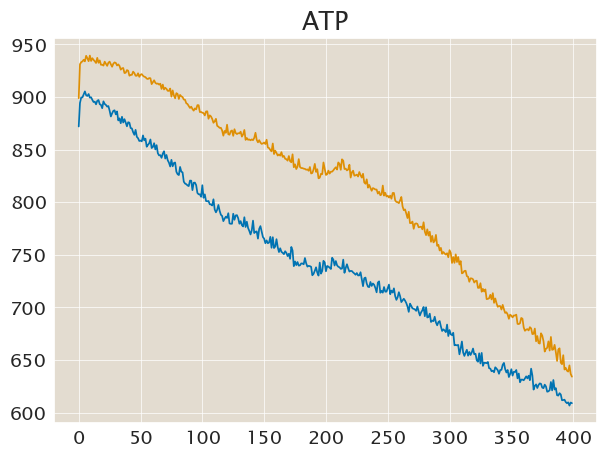

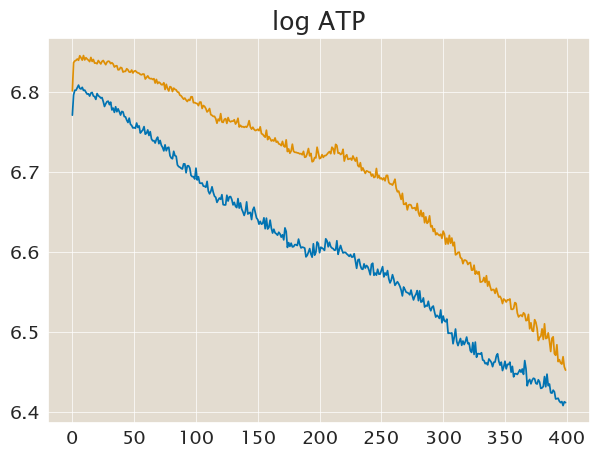

In [13]:

plt.figure(0); 
plt.title("ATP")
plt.figure(1); 
plt.title("log ATP")


for experiment in all_experiments:
    mean_ATP = np.mean(experiment['ratios_conc_ims'], axis=(1,2)); 
    plt.figure(0); 
    plt.plot(mean_ATP); 
    
    plt.figure(1); 
    plt.plot(np.log(mean_ATP)); 

## Extracting Hydrolysis Rates

Here we follow the two-step minimization process described in the overleaf document. Briefly,

Step I: Treat each curve as an exponential decay curve, $ATP(t) = ATP(0) e^{-\Gamma \, t}$. For each curve, extract $ATP(0)$ and $\Gamma$.

Step II: Using the set of intial ATP concentrations and $\Gamma$ from the previous step, extract $\frac{\gamma}{K_T}, K_D$ using the expression $\Gamma = \frac{\gamma}{K_T}\frac{m}{1 + \frac{ATP(0) + ADP(0)}{K_D}}$. See overleaf for derivation of expression.

### Step I

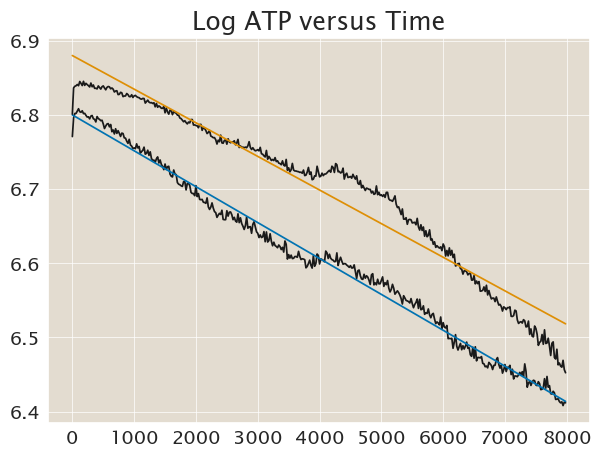

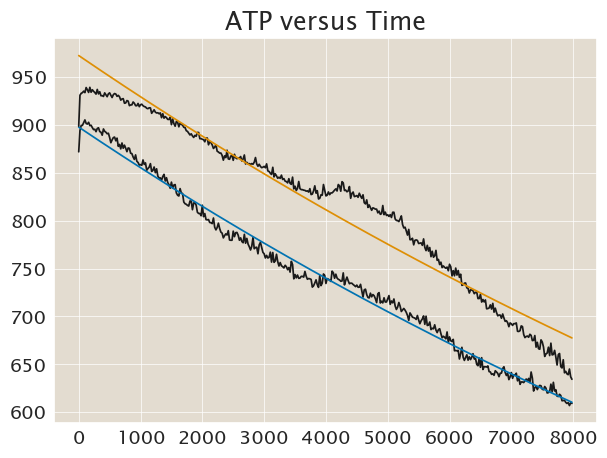

In [ ]:
gamma_array = []; 
log_atp0_array = []; 
atp0_array = []; 
adp0_array = []; 
p0_array = []; 

plt.figure(0); 
plt.title("Log ATP versus Time")

plt.figure(1); 
plt.title("ATP versus Time")

for experiment in all_experiments: 
    # Extract mean ATP from post-processed data
    mean_ATP = np.mean(experiment['ratios_conc_ims'], axis=(1,2)); 

    # Take logarithm of mean ATP
    log_mean_ATP = np.log(mean_ATP); 

    # Extract ATP(0), Gamma using linear regression
    time_interval = 20; # in seconds
    time = np.arange(0, 400*time_interval, time_interval); # Hardcode time assuming 20 second interval, to be replaced. 
    result = sp.stats.linregress(time, log_mean_ATP)

    log_atp0 = result[1]; 
    gamma = result[0]; 

    # Save in array
    gamma_array.append(gamma); 
    log_atp0_array.append(log_atp0); 


    # Plot theoretical curve with experimental curve
    plt.figure(0)
    plt.plot(time, log_mean_ATP, '-k')
    plt.plot(time, log_atp0 + gamma*time)

    plt.figure(1)
    plt.plot(time, mean_ATP, '-k')
    plt.plot(time, np.exp(log_atp0 + gamma*time))


    # TODO: take more frame numbers so that ATP value reaches 0, but skip frames in between to decrease computational expenses.


### Step II

In [ ]:
plt.plot(gamma, )

# Old Post Processing Visualisation

## Read Data from CSV Files

In [ ]:
# Specify location of csv file
directory = '../../analyzed_data/atp-hydro/';
csv_files = ['ATP.csv', 'ADP.csv', 'Phosphate.csv']
dataframes = []; 

for csv in csv_files: 
    csv_location = directory + csv;
    df = pd.read_csv(csv_location);
    dataframes.append(df); 

# Combine all dataframes into one dataframe
df_data = pd.concat(dataframes)

# Convert string-type ATP curves to array-type. 
df_data['ATP Curve (uM)'] = df_data["ATP Curve (uM)"].map(lambda curve: np.array(ast.literal_eval(curve))); 
df_data['Time Array (s)'] = df_data["Time Array (s)"].map(lambda curve: np.array(ast.literal_eval(curve))); 


In [ ]:
df_data["P Concentration (uM)"]*1000

In [ ]:
np.amax(df_data["ATP Concentration (uM)"] + df_data["ADP Concentration (uM)"] + df_data["P Concentration (uM)"]*1e3)

In [ ]:
# #### ------------- Load and Read Data ------------- ####
# ATP_conc_list = []
# ADP_conc_list = []
# P_conc_list = []
# ATP_curve_list = []
# ratio_curve_list = []
# linear_r2_list = []
# exponential_r2_list = []
# linear_hydrolysis_rate_list = []
# exponential_hydrolysis_rate_list = []
# times_list = []
# data_locations_list = []

# # for df in [df1]:
# # for df in [df1, df2, df3]:
# for df in dataframes[:1]:  # without phosphate data
#     # ATP Concentrations
#     ATP_conc_list.append(np.array(df["ATP Concentration (uM)"])); 

#     # ADP Concentrations
#     ADP_conc_list.append(np.array(df["ADP Concentration (uM)"])); 

#     # Phosphate Concentrations
#     P_conc_list.append(np.array(df["P Concentration (uM)"])); 

#     # ATP Curves
#     ATP_curve_list.append([ast.literal_eval(df["ATP Curve (uM)"][i]) for i in range(len(df))])

#     # Ratio Curves
#     ratio_curve_list.append([ast.literal_eval(df["Ratio (A.U.)"][i]) for i in range(len(df))])

#     # Goodness of Fit
#     linear_r2_list.append(np.array(df["r-squared for linear fit"])); 
#     exponential_r2_list.append(np.array(df["r-squared for exponential fit"])); 

#     # Hydrolysis Rate
#     linear_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Linear Fitting (-abs(Slope)/Motconc)"])); 
#     exponential_hydrolysis_rate_list.append(np.array(df["Hydrolysis Rate (uM/s/motor) from Exponential Curve"])); 

#     # Time
#     times_list.append([ast.literal_eval(df["Time Array (s)"][i]) for i in range(len(df))])
    
#     # Data location
#     data_locations_list.append(df["Data Location"])

    
# times_list = [item for sublist in times_list for item in sublist];
# ATP_conc_list = [item for sublist in ATP_conc_list for item in sublist]; 
# ADP_conc_list = [item for sublist in ADP_conc_list for item in sublist];
# P_conc_list = [item for sublist in P_conc_list for item in sublist];
# ATP_curve_list = [item for sublist in ATP_curve_list for item in sublist];
# ratio_curve_list = [item for sublist in ratio_curve_list for item in sublist];
# linear_r2_list = [item for sublist in linear_r2_list for item in sublist];
# exponential_r2_list = [item for sublist in exponential_r2_list for item in sublist];
# linear_hydrolysis_rate_list = [item for sublist in linear_hydrolysis_rate_list for item in sublist];
# exponential_hydrolysis_rate_list = [item for sublist in exponential_hydrolysis_rate_list for item in sublist];
# data_locations_list = [item for sublist in data_locations_list for item in sublist]; 

In [ ]:
# # Prepare data
# # remove_indices = [12, 26, 27, 46]; # manually select curves to not include
# remove_indices = []; 

# atp_array = []; 
# ytau_array = []; 
# atp0_array = []; 
# adp0_array = []; 
# p0_array = []; 
# time_array = []; 
# size_array = []; 

# j = 0; 
# for i, row in data.iterrows():
#     if i not in remove_indices: 
#         # if row["atp"][0]>500: 
#             if len(row["time"]) > 5:
#                 atp_array.append(row["atp"])
#                 ytau_array.append(row["atp"][0])
#                 atp0_array.append(row["atp0"])
#                 adp0_array.append(row["adp0"])
#                 p0_array.append(row["p0"])
#                 time_array.append(row["time"])
#                 size_array.append(len(row["atp"])); 
                
#                 j+=1; 

#                 # if j > 0: 
#                 #     break
# print(len(atp_array))

## Quality-Control Functions

In [ ]:
def quality_control(df_data, min_num_of_datapoints = 5): 

    # Curve should have enough points
    quality_controlled_df = df_data[df_data["ATP Curve (uM)"].map(lambda curve: len(curve) > min_num_of_datapoints)]; 

    # Remove curves with numerical instabilities - to be revisited later.
    quality_controlled_df = quality_controlled_df[quality_controlled_df["ATP Curve (uM)"].map(lambda curve: np.all(curve < 1e4))]; 

    return quality_controlled_df; 

## Visualize Data

In [ ]:
# Function to map a value to its corresponding color
def get_color(value, min_value = 0, max_value = 5000, cmap=cm.viridis):
    
    # Map value to the range [0, 1] (normalize)
    normalized_value = (value - min_value) / (max_value - min_value)

    # Get the color
    color = cmap(normalized_value)

    return color

In [ ]:
df_data#['Time Array (s)'].loc[69]

In [ ]:
end_time = 2; # in hours
adp0_array = list(set(df_data["ADP Concentration (uM)"])); # Extract all adp0 values used in dataset

# Run Quality Control 
quality_control_df = quality_control(df_data); 

for index, row in quality_control_df.iterrows():
    atp0 = row['ATP Concentration (uM)'];
    adp0 = row['ADP Concentration (uM)'];                  # Read initial ADP concentration of given row.

    if adp0 == 0: # Looking at specific adp0 values.
        time = row["Time Array (s)"]/3600; # Read time array of given row.
        atp_curve = row["ATP Curve (uM)"];           # Read ATP array of given row.
        color_from_adp0 = get_color(atp0, max_value=1420);             # Obtain color of curve based on initial adp concentration
    
        if np.where(time < end_time)[0].size != 0: # Ensure array is not empty.
            end_index = np.where(time < end_time)[0][-1]; 
            print(time[0])
        else: 
            end_index = -1; # If time of data collection is less than end_time, take entire dataset. 
        
        plt.plot(time[:end_index], atp_curve[:end_index], color = color_from_adp0); 

plt.ylim([0, 1000])
plt.xlim([0, 2])

plt.xlabel("Time (hours)"); 
plt.ylabel("ATP (μM)"); 

plt.show()

In [ ]:
# #### ALL ATP VS TIME PLOTS, COLOR CODED BY ADP0 VALUES

# color_mapper = LinearColorMapper(palette=Viridis256, low=min(adp0_array), high=list(set(adp0_array))[-2])

# # Function to map a value to its corresponding color
# def get_color(value, total_array):
#     second_largest_value = list(set(total_array))[-2]
#     # Map value to the range [0, 1] (normalize)
#     normalized_value = (value - min(total_array)) / (second_largest_value - min(total_array))
#     # Get the color index from the palette
#     index = int(normalized_value * (len(Viridis256) - 1))
#     # Get the color code
#     color = Viridis256[index]
#     return color

# start_index = 0; 

# # Create a ColumnDataSource
# source = ColumnDataSource(data=dict(x=time_array, y=atp_array, values=adp0_array))

# # Create figure
# p = figure(width=400, height=400, title="ATP vs Time Curves")

# df_data[["Time Array (s)", "ATP Curve (uM)", "ATP Concentration (uM)", "ADP Concentration (uM)", "P Concentration (uM)"]]

# for time_data, atp_data, atp0, adp0, p0 in zip(time_array, atp_array, atp0_array, adp0_array, p0_array): 

#     if np.where(time_data < 2*3600)[0].size != 0: 
#         end_index = np.where(time_data < 2*3600)[0][-1]; 
#     else: 
#         end_index = -1; 
    
#     if adp0 <= 1420: 
#         # atp = atp_data[start_index:end_index]; 
#         # time = np.array(time_data[start_index:end_index])/3600; 

#         atp = atp_data; 
#         time = np.array(time_data)/3600; 

#         color = get_color(adp0, adp0_array); 

#         # Add circle glyphs with color mapping
#         p.line(time, atp, color=color)

 
# # Create a color bar
# color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
#                      formatter=PrintfTickFormatter(format="%d"), 
#                      title = "Initial Concetration of ADP (μM)")

# # Add color bar to plot
# p.add_layout(color_bar, 'right')
# p.xaxis.axis_label = "Time (hours)"; 
# p.yaxis.axis_label = "ATP (μM)"; 

# # show(gridplot([[p3, p4]]))
# show(p)
# # show(p4)
